<h1> Multiagent frameworks in action <h1>
<h3>  Practical guide for implementing stateful, multiagent orchestrations using top-4 frameworks. </h3>
<p> </p>


### Autogen

Create a new python virtual environment and install the required packages. `python -m venv autogen .`

Multi-agent interaction patterns supported by Autogen
- **RoundRobinGroupChat**: A team that runs a group chat with participants taking turns in a round-robin fashion (covered on this page). 
- **SelectorGroupChat**: A team that selects the next speaker using a ChatCompletion model after each message. 
- **MagenticOneGroupChat**: A generalist multi-agent system for solving open-ended web and file-based tasks across a variety of domains. 
- **Swarm**: A team that uses HandoffMessage to signal transitions between agents. 


In this section we will be using `SelectorGroupChat`

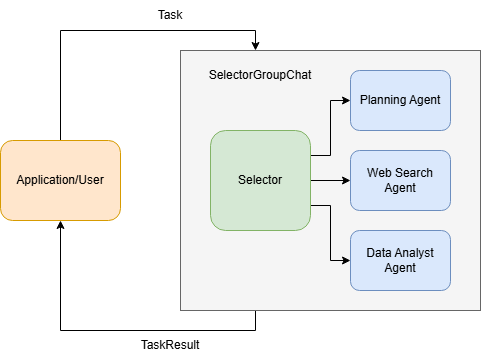


**Note:** While AutoGen is a powerful tool for building multi-agent systems and is actively used for rapid prototyping and research, it's generally not considered production-ready in its current state. 
https://devblogs.microsoft.com/semantic-kernel/microsofts-agentic-ai-frameworks-autogen-and-semantic-kernel/

In [25]:
%pip install -q "autogen-agentchat" "autogen-ext[azure]" "python-dotenv" "aiohttp" "ddgs" "langchain-community" "langchain-core" "playwright" "beautifulsoup4"

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [18]:
from dotenv import load_dotenv
import os

load_dotenv()  
model = os.getenv("AOAI_CHAT_DEPLOYMENT_NAME", "gpt-4o")
endpoint = os.getenv("AZURE_OPENAI_ENDPOINT")
key = os.getenv("AZURE_OPENAI_API_KEY")

In [ ]:
import asyncio
from autogen_agentchat.agents import AssistantAgent
from autogen_agentchat.ui import Console
from autogen_ext.models.openai import AzureOpenAIChatCompletionClient
from autogen_agentchat.conditions import MaxMessageTermination, TextMentionTermination
from autogen_agentchat.teams import SelectorGroupChat
from ddgs import DDGS
from langchain_community.document_loaders import AsyncChromiumLoader
from langchain_community.document_transformers import BeautifulSoupTransformer
import re


az_model_client = AzureOpenAIChatCompletionClient(
    azure_deployment="gpt-4o",
    model="gpt-4o-2024-11-20",
    api_version="2024-08-01-preview",
    azure_endpoint=endpoint
)

ddgs = DDGS()

def web_search(query: str) -> str:
    """Perform a web search using DuckDuckGo and return the first result."""
    try:
      results = ddgs.text(query, max_results=1)
      print(f"Search results for query '{query}': {results}")
      content = []
      for result in results:
          body = result['body']
          content.append(body)
      return content
    except Exception as e:
      print(f"Error during web search: {e}")
      return f"Error: {e}"

def percentage_change_tool(start: float, end: float) -> float:
    return ((end - start) / start) * 100


planning_agent = AssistantAgent(
    name="PlanningAgent",
    description="An agent for planning tasks, this agent should be the first to engage when given a new task.",
    model_client=az_model_client,
    system_message="""
    You are a planning agent.
    Your job is to break down complex tasks into smaller, manageable subtasks.
    Your team members are:
        WebSearchAgent: Searches for information
        DataAnalystAgent: Performs calculations

    You only plan and delegate tasks - you do not execute them yourself.

    When assigning tasks, use this format:
    1. <agent> : <task>

    After all tasks are complete, summarize the findings and end with "TERMINATE".
    """,
)

search_agent = AssistantAgent(
    name="WebSearchAgent",
    description="An agent that performs web searches to gather information.",
    tools=[web_search],
    system_message="You are a web search agent. \
    Your only tool is search_tool - use it to find information. \
    You make only one search call at a time. \
    Once you have the results, you never analyze data.",
    model_client=az_model_client
)

data_analyst_agent = AssistantAgent(
    name="DataAnalystAgent",
    description="An agent for performing financial data analysis.",
    model_client=az_model_client,
    tools=[percentage_change_tool],
    system_message="""
    You are a financial data analyst.
    Given the tasks you have been assigned, you should analyze the data and provide results using the tools provided.
    If you have not seen the data, ask for it.
    """,
)

text_mention_termination = TextMentionTermination("TERMINATE")
max_messages_termination = MaxMessageTermination(max_messages=25)
termination = text_mention_termination | max_messages_termination


selector_prompt = """Select an agent to perform task.
{roles}
Current conversation context:
{history}
Read the above conversation, then select an agent from {participants} to perform the next task.
Make sure the planner agent has assigned tasks before other agents start working.
Only select one agent.
"""


# Magentic-One is powerful, generalist multi-agent system, while using Magentic-One as a teams pattern we have to ensure the agents have just-enough capabilities to solve the task at hand. 
team = SelectorGroupChat([search_agent, planning_agent, data_analyst_agent], model_client=az_model_client,  termination_condition=termination,
    selector_prompt=selector_prompt,
    allow_repeated_speaker=False)

# Run the agent and stream the messages to the console.
async def main() -> None:
   await Console(team.run_stream(task="Create a financial report for Zomato considering last 5 years. Analyze the data and summarize impact if leadership change, aquistions, news and updates on stock prices"),  output_stats=True)
   await az_model_client.close()

# NOTE: if running this inside a Python script you'll need to use asyncio.run(main()).
await main()

---------- TextMessage (user) ----------
Create a financial report for Zomato considering last 5 years. Analyze the data and summarize impact if leadership change, aquistions, news and updates on stock prices
---------- TextMessage (PlanningAgent) ----------
To create this financial report for Zomato, we need to gather, analyze, and synthesize data from multiple sources to comprehensively understand how leadership changes, acquisitions, and news have influenced the company’s stock prices over the last five years. Here’s the step-by-step breakdown:

### Step 1: Gather Financial and Business Data for Zomato
1. **WebSearchAgent**: Collect yearly financial data (profit/loss, revenue, expenses) for Zomato over the last 5 years.
2. **WebSearchAgent**: Research major leadership changes at Zomato over the last 5 years, including CEO/chairperson changes and their dates.
3. **WebSearchAgent**: Identify all acquisitions made by Zomato in the last 5 years and their significance.
4. **WebSearchAgen